In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import os
import shutil
import yaml

import pandas as pd
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [72]:
import shutil
import os

def clean_kaggle_working():
    """Delete all contents of /kaggle/working directory"""
    for filename in os.listdir('/kaggle/working'):
        file_path = os.path.join('/kaggle/working', filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

clean_kaggle_working()

Deleted: /kaggle/working/yolov8n.pt
Deleted: /kaggle/working/yolo11n.pt
Deleted: /kaggle/working/dataset
Deleted: /kaggle/working/runs


In [73]:
os.mkdir("/kaggle/working/dataset/")

In [74]:

os.mkdir("/kaggle/working/dataset/images")
os.mkdir("/kaggle/working/dataset/labels")

In [75]:
full_input_path = f"/kaggle/input/weapon-dataset-for-yolov5/dataset/dataset/images/train"
full_working_path = f"/kaggle/working/dataset/images/train"
print(f"Copying from {full_input_path} to {full_working_path}...")
shutil.copytree(full_input_path, full_working_path)

Copying from /kaggle/input/weapon-dataset-for-yolov5/dataset/dataset/images/train to /kaggle/working/dataset/images/train...


'/kaggle/working/dataset/images/train'

In [76]:
full_input_path = f"/kaggle/input/weapon-dataset-for-yolov5/dataset/dataset/images/val"
full_working_path = f"/kaggle/working/dataset/images/val"
print(f"Copying from {full_input_path} to {full_working_path}...")
shutil.copytree(full_input_path, full_working_path)

Copying from /kaggle/input/weapon-dataset-for-yolov5/dataset/dataset/images/val to /kaggle/working/dataset/images/val...


'/kaggle/working/dataset/images/val'

In [77]:
# input_count,working_count

In [78]:
full_input_path = f"/kaggle/input/weapon-dataset-for-yolov5/dataset/dataset/labels/train"
full_working_path = f"/kaggle/working/dataset/labels/train"
print(f"Copying from {full_input_path} to {full_working_path}...")
shutil.copytree(full_input_path, full_working_path)

Copying from /kaggle/input/weapon-dataset-for-yolov5/dataset/dataset/labels/train to /kaggle/working/dataset/labels/train...


'/kaggle/working/dataset/labels/train'

In [79]:
full_input_path = f"/kaggle/input/weapon-dataset-for-yolov5/dataset/dataset/labels/val"
full_working_path = f"/kaggle/working/dataset/labels/val"
print(f"Copying from {full_input_path} to {full_working_path}...")
shutil.copytree(full_input_path, full_working_path)

Copying from /kaggle/input/weapon-dataset-for-yolov5/dataset/dataset/labels/val to /kaggle/working/dataset/labels/val...


'/kaggle/working/dataset/labels/val'

In [80]:
input_count = sum(len(files) for _, _, files in os.walk(full_input_path))
working_count = sum(len(files) for _, _, files in os.walk(full_working_path))

In [81]:
input_count,working_count

(156, 156)

In [82]:
!pip install ultralytics

In [83]:
import yaml
from ultralytics import YOLO

In [84]:
data_config = {
    'path': '/kaggle/working/dataset',
    'train': 'images/train',
    'val': 'images/val',
    'nc': 2,  # Number of classes
    'names': ['Knife', 'Handgun'],# Class names
     'cls_pw': [1.5,1.0],
    # data.yaml
'anchors': [
        [5,6, 8,12, 10,16],     # P3 (small objects)
        [12,24, 16,32, 20,40],   # P4 (medium)
        [32,64, 48,96, 64,128]   # P5 (large, for handguns)
    ]
}

In [86]:
with open('/kaggle/working/dataset/data.yaml', 'w') as f:
    yaml.dump(data_config, f)

In [87]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 80.4MB/s]


##### results = model.train(
    data='/kaggle/working/dataset/data.yaml',
    epochs=50,

In [88]:

results = model.train(
    data='/kaggle/working/dataset/data.yaml',
    epochs=50,                    # Increased for convergence
    imgsz=320,                    # Higher resolution for small knives
    batch=8,                      # Keep if GPU memory permits
    device='cuda',
    
    # --- Hyperparameters ---
    lr0=0.0005,                   # Smoother learning (AdamW prefers lower LR)
    lrf=0.0001,                   # Fine-tuning phase
    optimizer='AdamW',
    weight_decay=0.01,            # Less aggressive regularization
    
    # --- Augmentations ---
    hsv_h=0.01,                   # Reduced hue variation
    hsv_s=0.5, hsv_v=0.3,         # Less saturation/brightness noise
    degrees=5,                    # Smaller rotations
    flipud=0.1, fliplr=0.3,       # Fewer flips
    mosaic=0.3,                   # Lower mosaic to preserve knife features
    mixup=0.0,                    # Disable mixup (can blur small objects)
    copy_paste=0.1,               # Rarely use
    
    # --- Loss Balancing ---
    box=5.0, cls=1.5,             # Higher cls weight to boost confidence
    dfl=1.0,                      # Default DFL
    
    # --- Regularization ---
    dropout=0.1,                  # Mild dropout
    label_smoothing=0.05,         # Less smoothing
    
    # --- Monitoring ---
    val=True,
    plots=True,
    patience=15,                  # Stop if no improvement
    workers=4
)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.160 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=5.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/data.yaml, degrees=5, deterministic=True, device=0, dfl=1.0, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.3, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.5, hsv_v=0.3, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.3, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW,

100%|██████████| 5.35M/5.35M [00:00<00:00, 71.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 679.1±251.6 MB/s, size: 37.7 KB)


train: Scanning /kaggle/working/dataset/labels/train... 4000 images, 2 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:02<00:00, 1517.48it/s]


train: New cache created: /kaggle/working/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 223.4±139.5 MB/s, size: 57.3 KB)


val: Scanning /kaggle/working/dataset/labels/val... 156 images, 0 backgrounds, 0 corrupt: 100%|██████████| 156/156 [00:00<00:00, 937.34it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.822G      1.032      6.256      1.022         12        320: 100%|██████████| 500/500 [00:38<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.68it/s]

                   all        156        190      0.355      0.339      0.293      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.838G     0.9539      4.849     0.9544         12        320: 100%|██████████| 500/500 [00:34<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]

                   all        156        190       0.51      0.491      0.491      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.855G     0.9486      4.618     0.9441         18        320: 100%|██████████| 500/500 [00:34<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 14.13it/s]

                   all        156        190      0.496      0.504      0.492      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.871G     0.9081      4.267     0.9197         10        320: 100%|██████████| 500/500 [00:34<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.87it/s]

                   all        156        190      0.447      0.389      0.393      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.889G     0.8915       4.13     0.9146         17        320: 100%|██████████| 500/500 [00:33<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.67it/s]

                   all        156        190      0.645      0.518      0.553      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.904G     0.9001      3.993     0.9077         10        320: 100%|██████████| 500/500 [00:33<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.41it/s]

                   all        156        190      0.572      0.504      0.533      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.924G     0.8856      3.809     0.8976         10        320: 100%|██████████| 500/500 [00:34<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.96it/s]

                   all        156        190      0.588      0.621      0.569      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.939G     0.8673      3.742     0.8936         17        320: 100%|██████████| 500/500 [00:34<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.81it/s]

                   all        156        190      0.637      0.582      0.597       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.957G     0.8581      3.612     0.8824         10        320: 100%|██████████| 500/500 [00:35<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.17it/s]

                   all        156        190      0.614        0.6      0.601      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.973G     0.8484      3.583     0.8803         12        320: 100%|██████████| 500/500 [00:35<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.95it/s]

                   all        156        190      0.654      0.567      0.578      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      0.99G     0.8416      3.515      0.875         16        320: 100%|██████████| 500/500 [00:36<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.06it/s]

                   all        156        190      0.623      0.576      0.595      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.01G     0.8318       3.39     0.8664         10        320: 100%|██████████| 500/500 [00:35<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.56it/s]

                   all        156        190      0.647      0.579      0.616      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.02G     0.8402      3.395      0.864         11        320: 100%|██████████| 500/500 [00:35<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.27it/s]

                   all        156        190       0.64      0.621      0.627      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.04G     0.8086      3.242      0.854         22        320: 100%|██████████| 500/500 [00:35<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 11.12it/s]

                   all        156        190      0.661      0.619      0.627      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.06G     0.8218      3.248     0.8577         13        320: 100%|██████████| 500/500 [00:34<00:00, 14.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.05it/s]

                   all        156        190       0.66      0.619      0.634      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.08G       0.81      3.229     0.8477          9        320: 100%|██████████| 500/500 [00:34<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.88it/s]

                   all        156        190      0.649      0.553      0.608      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.09G     0.7978      3.149     0.8515         11        320: 100%|██████████| 500/500 [00:34<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.28it/s]

                   all        156        190      0.552      0.604      0.591      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.11G     0.8052      3.158      0.849          9        320: 100%|██████████| 500/500 [00:34<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.76it/s]

                   all        156        190       0.68      0.566      0.627      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.13G     0.8093      3.114     0.8462         11        320: 100%|██████████| 500/500 [00:34<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.92it/s]

                   all        156        190      0.665      0.606      0.634      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.14G     0.7911      3.073     0.8413         13        320: 100%|██████████| 500/500 [00:34<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.84it/s]

                   all        156        190      0.647      0.609      0.643      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.16G     0.7889       3.02     0.8366          9        320: 100%|██████████| 500/500 [00:34<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 14.11it/s]

                   all        156        190      0.667      0.632      0.649      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.18G     0.7743      2.975       0.83         13        320: 100%|██████████| 500/500 [00:34<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 11.52it/s]

                   all        156        190      0.662       0.62      0.656      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       1.2G     0.7772      2.938      0.836         13        320: 100%|██████████| 500/500 [00:34<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.72it/s]

                   all        156        190      0.702      0.617      0.634      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.21G     0.7709      2.931     0.8316          9        320: 100%|██████████| 500/500 [00:34<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.92it/s]

                   all        156        190      0.626      0.648      0.648      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.23G     0.7793      2.908     0.8298         10        320: 100%|██████████| 500/500 [00:34<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.51it/s]

                   all        156        190      0.605       0.63      0.636       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.25G     0.7717      2.852     0.8259         12        320: 100%|██████████| 500/500 [00:34<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.34it/s]

                   all        156        190      0.695      0.629      0.662      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.26G     0.7643      2.822     0.8207         11        320: 100%|██████████| 500/500 [00:34<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.89it/s]

                   all        156        190      0.688        0.6       0.67      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.28G      0.764      2.794     0.8192         10        320: 100%|██████████| 500/500 [00:34<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.60it/s]

                   all        156        190      0.685      0.634      0.674       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       1.3G     0.7598       2.76     0.8145         14        320: 100%|██████████| 500/500 [00:34<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 14.11it/s]

                   all        156        190      0.697      0.642      0.677      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.31G     0.7483      2.701     0.8161          8        320: 100%|██████████| 500/500 [00:34<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.38it/s]

                   all        156        190       0.72      0.554      0.627      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.33G     0.7546      2.766     0.8161         10        320: 100%|██████████| 500/500 [00:34<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 14.26it/s]

                   all        156        190      0.646      0.639      0.652      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.35G     0.7462      2.676     0.8164         14        320: 100%|██████████| 500/500 [00:33<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.94it/s]

                   all        156        190      0.706      0.657      0.681      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.37G      0.741      2.649     0.8086         11        320: 100%|██████████| 500/500 [00:33<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.57it/s]

                   all        156        190      0.684      0.643       0.67      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.38G     0.7461      2.614      0.809          8        320: 100%|██████████| 500/500 [00:34<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.13it/s]

                   all        156        190      0.642      0.585      0.646      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       1.4G     0.7376      2.571     0.8049         12        320: 100%|██████████| 500/500 [00:34<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.52it/s]

                   all        156        190      0.721      0.637      0.682       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.42G     0.7373      2.578     0.8049         12        320: 100%|██████████| 500/500 [00:34<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.76it/s]

                   all        156        190      0.634      0.655      0.669      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.43G     0.7259      2.527     0.7953         19        320: 100%|██████████| 500/500 [00:34<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.30it/s]

                   all        156        190      0.683      0.596      0.677       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.45G     0.7365      2.582     0.8018         18        320: 100%|██████████| 500/500 [00:34<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.93it/s]

                   all        156        190      0.705      0.616      0.659      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.47G     0.7273      2.484     0.7965         10        320: 100%|██████████| 500/500 [00:34<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 11.59it/s]

                   all        156        190      0.604       0.61       0.63      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.48G     0.7182      2.457     0.7904          8        320: 100%|██████████| 500/500 [00:34<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.61it/s]

                   all        156        190      0.729      0.622      0.697      0.366


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       1.5G     0.7156      2.259     0.7833          8        320: 100%|██████████| 500/500 [00:34<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.79it/s]

                   all        156        190      0.667      0.626      0.645      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.52G     0.7119      2.201     0.7846         10        320: 100%|██████████| 500/500 [00:34<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.87it/s]

                   all        156        190      0.666      0.574       0.63      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.54G      0.704      2.155     0.7795          8        320: 100%|██████████| 500/500 [00:34<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.84it/s]

                   all        156        190      0.678      0.659      0.674      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.55G     0.7014      2.157      0.778          8        320: 100%|██████████| 500/500 [00:34<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.95it/s]

                   all        156        190      0.656      0.643      0.667      0.361
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 29, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



44 epochs completed in 0.436 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.20it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        156        190      0.699      0.643      0.677      0.371
                 Knife         78         90      0.647      0.533      0.566      0.208
               Handgun         78        100      0.751      0.754      0.789      0.535
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train



image 1/1 /kaggle/working/dataset/images/val/4084.jpg: 320x320 3 Knifes, 10.4ms
Speed: 1.3ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 320)

image 1/1 /kaggle/working/dataset/images/val/4103.jpg: 320x320 (no detections), 6.6ms
Speed: 0.8ms preprocess, 6.6ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 320)

image 1/1 /kaggle/working/dataset/images/val/2078.jpg: 224x320 1 Handgun, 7.4ms
Speed: 0.8ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)

image 1/1 /kaggle/working/dataset/images/val/4129.jpg: 320x320 4 Knifes, 7.4ms
Speed: 0.9ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)

image 1/1 /kaggle/working/dataset/images/val/4099.jpg: 320x320 (no detections), 6.4ms
Speed: 0.9ms preprocess, 6.4ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 320)

image 1/1 /kaggle/working/dataset/images/val/4119.jpg: 320x320 1 Knife, 6.5ms
Speed: 0.8ms preprocess,

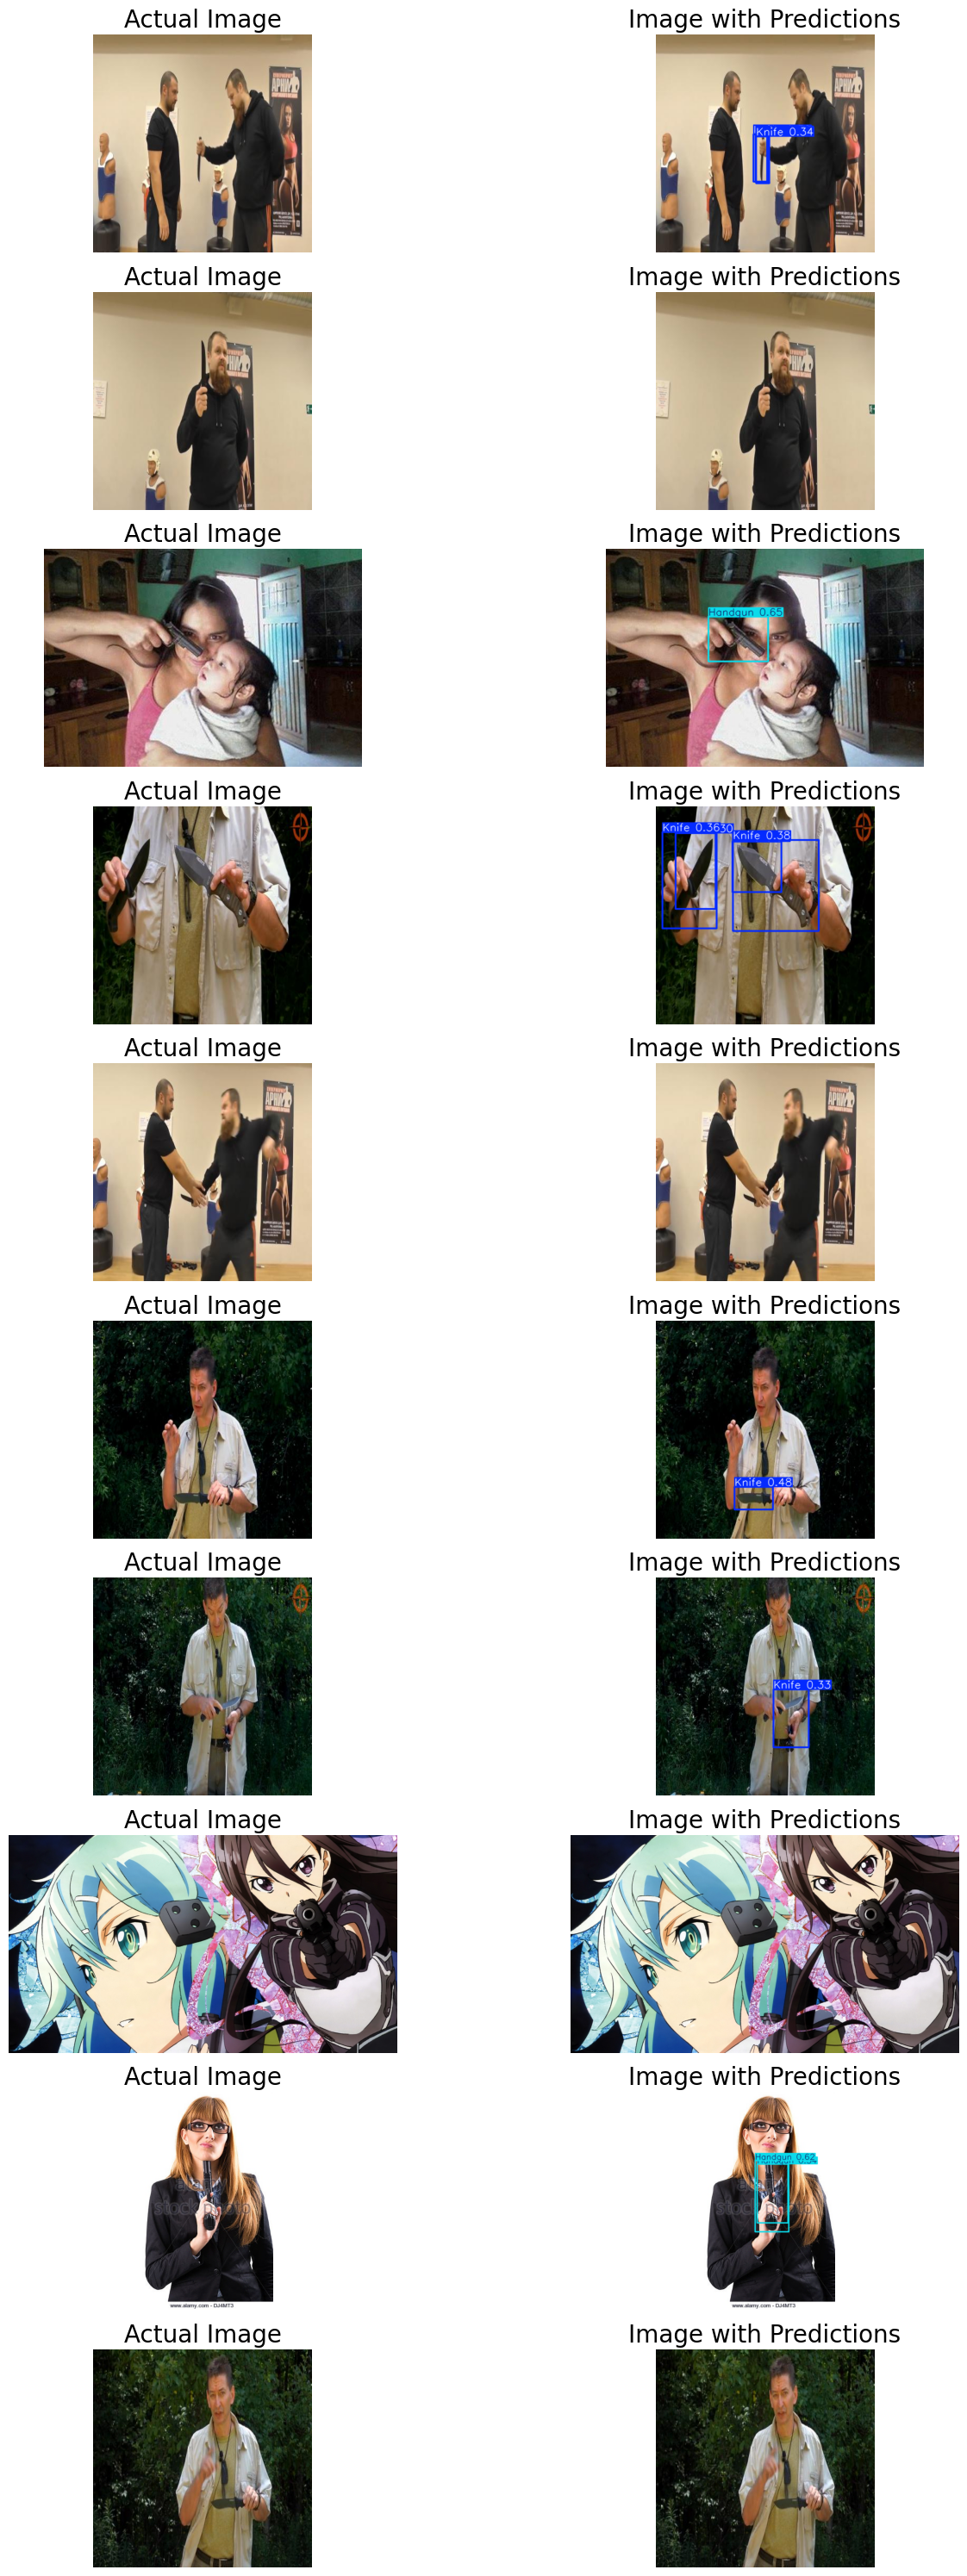

In [92]:
import random
import cv2
import matplotlib.pyplot as plt
imgtestpath = "/kaggle/working/dataset/images/val"


n = 10
test_images = random.sample(os.listdir(imgtestpath), n)

plt.figure(figsize=(15, 30))

for idx, img_name in enumerate(test_images):
    # Full path to the test image
    test_image_path = os.path.join(imgtestpath, img_name)

    # Read and display the actual image
    ax = plt.subplot(n, 2, 2 * idx + 1)
    image = cv2.imread(test_image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("Actual Image", fontsize=20)

    # Predict using the YOLO model
    res = model.predict(test_image_path, iou=0.8, conf=0.3)
    res_plotted = res[0].plot()  # Get the annotated image from YOLO

    # Display image with predictions
    ax = plt.subplot(n, 2, 2 * idx + 2)
    plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Image with Predictions", fontsize=20)

# Show the plots
plt.tight_layout()
plt.show()
